In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import waterfall_chart

## Wczytanie danych

In [6]:
df = pd.read_stata("HCMST 2017 fresh sample for public sharing draft v1.1.dta")

## Przygotwanie zmiennych

Najpierw konwertujemy odpowiedź `S1` na zmienną binarną, gdzie 1 odpowiada informacji `Yes, I am Married`

In [7]:
df['y'] = 1 - df['S1'].cat.codes

### Wybrane zmienne

Do modelu wybrałem następujące zmienne  
1) kategoryczne:  
  a) `Q23` - Between you and [Partner name], who earned more income in 2016,  
  b) `Q28` - Did your parents know [Partner name]’s parents before you met [Partner name]?,  
2) uporządkowane:  
  a) `ppp20072` - Q27: How often do you attend religious services?,  
  b) `w6_how_many` - How many Different people besides [Partner name] have you met for dating, or rom   

Wszystkie zmienne są zakodowane przez kategorię, które odkoduję.

In [8]:
df = df.dropna(subset=['Q23', 'Q28', 'ppp20072', 'w6_how_many'])

In [9]:
X = df[['Q23', 'Q28', 'ppp20072', 'w6_how_many']].apply(lambda x: x.cat.codes, axis=0)
y = df['y']

In [10]:
X.shape

(225, 4)

Zostało nam 225 obserwacji co oznacza, że nie ma sensu uczyć modelu o dużej pojemności. Z tego powodu wybrałem las losowy o 25 drzewach i maksymalnej głębokości 3.

Stworzymy dodatkowo słowniki do zmiennych kategorycznych by łatwiej odwikłać potem kategorię.

In [11]:
d_ppp20072 = dict(enumerate(df['ppp20072'].cat.categories))
d_w6_how_many = dict(enumerate([cat.split(".")[0] for cat in df['w6_how_many'].cat.categories]))

In [12]:
d = {
    'ppp20072': d_ppp20072,
    'w6_how_many': d_w6_how_many
}

## Budowa modelu

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [14]:
rf = RandomForestClassifier(n_estimators=25, max_depth=4)

In [15]:
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Reszty na zbiorze treningowym

In [56]:
from pygam import LinearGAM

In [58]:
res = y - rf.predict_proba(X)[:,1]
gam = LinearGAM()
gam.fit(rf.predict_proba(X)[:,1], res)

grid = gam.generate_X_grid(term=0, n=100)

smooth_index = grid > 0
x_smooth = grid[smooth_index]
y_smooth = gam.partial_dependence(term=0, X=grid)[smooth_index.flatten()]

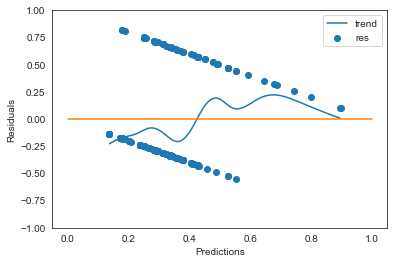

In [55]:
plt.scatter(x=rf.predict_proba(X)[:,1], y=res, label="res")
plt.ylim(-1,1)
plt.plot(x_smooth, y_smooth, label="trend")
plt.plot(np.linspace(0,1,100), np.zeros(100));
plt.legend()
plt.xlabel('Predictions');
plt.ylabel('Residuals');

Krzywa lokalnego trendu jest zdecydowanie różna od zera, wartości o predykcji bliskiej zera mają średnio zdecydowanie mniejsza residua niż wartości o dużym przewidzianym p-stwie. Może to świadczyć o tym że wartości o predykcji bliskiej zera są często zerami, więc residua są częściej ujemne. Analogiczna sytuacja zachodzi dla residuów dla obserwacji z dużym p-stwem. 

## Residua a wartość zmiennej

In [65]:
gam = LinearGAM()
gam.fit(X['w6_how_many'], res)

grid = gam.generate_X_grid(term=0, n=100)

smooth_index = grid > 0
x_smooth = grid[smooth_index]
y_smooth = gam.partial_dependence(term=0, X=grid)[smooth_index.flatten()]

res = y - rf.predict_proba(X)[:,1]

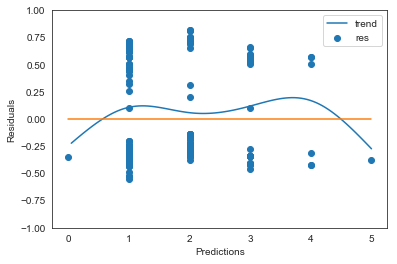

In [66]:
plt.scatter(x=X['w6_how_many'], y=res, label="res")
plt.ylim(-1,1)
plt.plot(x_smooth, y_smooth, label="trend")
plt.plot(np.linspace(0,5,100), np.zeros(100));
plt.legend()
plt.xlabel('Predictions');
plt.ylabel('Residuals');

Jak widać residua nie są równe zera dla każdej wartości zmiennej i możemy stwierdzić, że są znacząco różne. Model ma problemy dla wartości skrajnych 0 i  5 ponieważ zawsze daje tam za wysokie p-stwo. Rónwnież widać, że dla wartości 2 residua nie są symetrycznie rozłożone wobec punktu 0.

## Wartości Cooka


In [74]:
rf_new = RandomForestClassifier()
cooks = []
for idx in df.index:
    X_new = X.drop(idx)
    y_new = y.drop(idx)
    rf_new.fit(X_new, y_new)
    cooks.append(np.mean((rf_new.predict_proba(X)[:,1] - rf.predict_proba(X)[:,1])**2))

C:\Users\Olaf\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


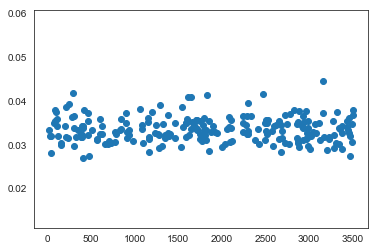

In [75]:
plt.scatter(df.index, cooks)

Odległości Cooka wyglądają bardzo dobrze, żadna obserwacja nie ma znacząco większego wpływu na model niż inne. Wiążę się to z tym, że  metody drzewiaste z reguły są bardziej odporne na outliery niż inne metody, co wynika z ich sposobu budowy.